100%|██████████| 15000/15000 [00:06<00:00, 2155.61it/s]
/Users/milesporter/data-science/udacity_data_sci/py3_fwk_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ok, now what?
lambda_a_samples: [ 13.18802626  13.13897114  13.13897114 ...,  12.95536579  13.10134055
  13.10134055]
Tau samples: [1108 1108 1110 ..., 1110 1110 1110]


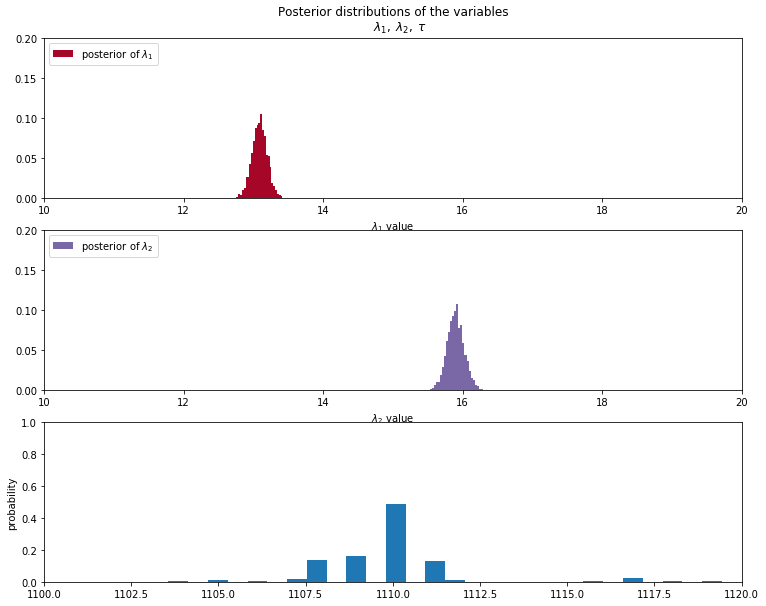

Got to here.


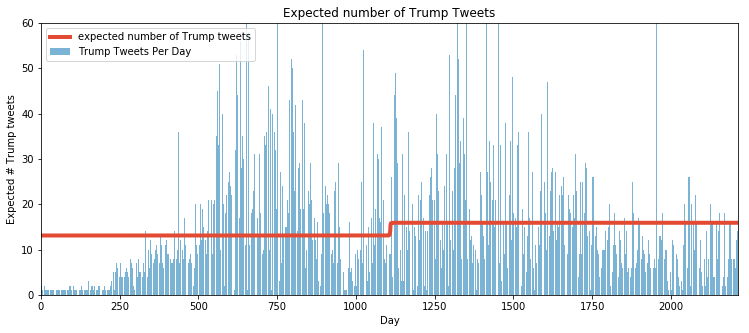

In [53]:
%matplotlib inline
import pandas as pd
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

count_data_df = pd.read_csv('./data/trump_daily_counts.csv')
count_data = count_data_df["count"]
n_count_data = len(count_data)

with pm.Model() as model:
    #alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    alpha1 = 0.2
    alpha2 = 0.75
    lambda_1 = pm.Exponential("lambda_1", alpha1)
    lambda_2 = pm.Exponential("lambda_2", alpha2)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)    
    

### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

print("Ok, now what?")

figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
w1 = 1.0 / lambda_1_samples.shape[0] * np.ones_like(lambda_1_samples)
ax.set_autoscaley_on(False)
print("lambda_a_samples: {0}".format(lambda_1_samples))
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, weights=w1,
         label="posterior of $\lambda_1$", color="#A60628")
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([10, 20])
plt.ylim([0,.2])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
w2 = 1.0 / lambda_2_samples.shape[0] * np.ones_like(lambda_2_samples)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, weights=w2,
         label="posterior of $\lambda_2$", color="#7A68A6")
plt.legend(loc="upper left")
plt.xlim([10, 20])
plt.ylim([0,.2])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w3 = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
print("Tau samples: {0}".format(tau_samples))
plt.hist(tau_samples, bins=30, weights=w3)
#plt.hist(tau_samples, bins=n_count_data, alpha=1,
#         label=r"posterior of $\tau$",
#         color="#467821", weights=w, rwidth=2.)
#plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, 1.0])
plt.xlim([1100, 1120])
#plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

plt.show()
print("Got to here.")

figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of Trump tweets")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # Trump tweets")
plt.title("Expected number of Trump Tweets")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="Trump Tweets Per Day")

plt.legend(loc="upper left");
